## Introduction

In this Jupyter Notebook, I explore a dataset containing all the candidates who ran in Uruguay’s October 2024 elections. These elections feature a national circunscription for the Senate and 19 departmental circunscriptions for both the House of Representatives and the electoral committees. For the purposes of this analysis, I pool all the candidates together. To determine each candidate’s place of origin, I use the location where they cast their votes.

I begin by examining the number of candidates fielded by each of the four major parties—Frente Amplio (FA), Partido Nacional (PN), Partido Colorado (PC), and Cabildo Abierto—which together received the most votes. Next, I investigate the regional distribution of these candidates across Uruguay, looking at both overall and party-specific proportions of candidates in each region.

From there, I assess how many voters also appeared as candidates in each city, disaggregated by party, and explore whether the number of candidates from a city correlates with that city’s votes for each party. Afterward, I calculate the share of voters who were also candidates in cities throughout Canelones and neighborhoods in Montevideo, visualizing these results on maps.

Finally, I incorporate data on Unmet Basic Needs to examine whether the number of candidates from each city correlates with these socioeconomic measures. This analysis aims to shed light on the interplay among party representation, voter-candidate overlap, and broader socioeconomic factors across Uruguay.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from scipy.stats import linregress

In [2]:
folder='data/'
df=pd.read_excel(folder+'-integracion-de-hojas-de-votacion-eleccion-nacional.xlsx')

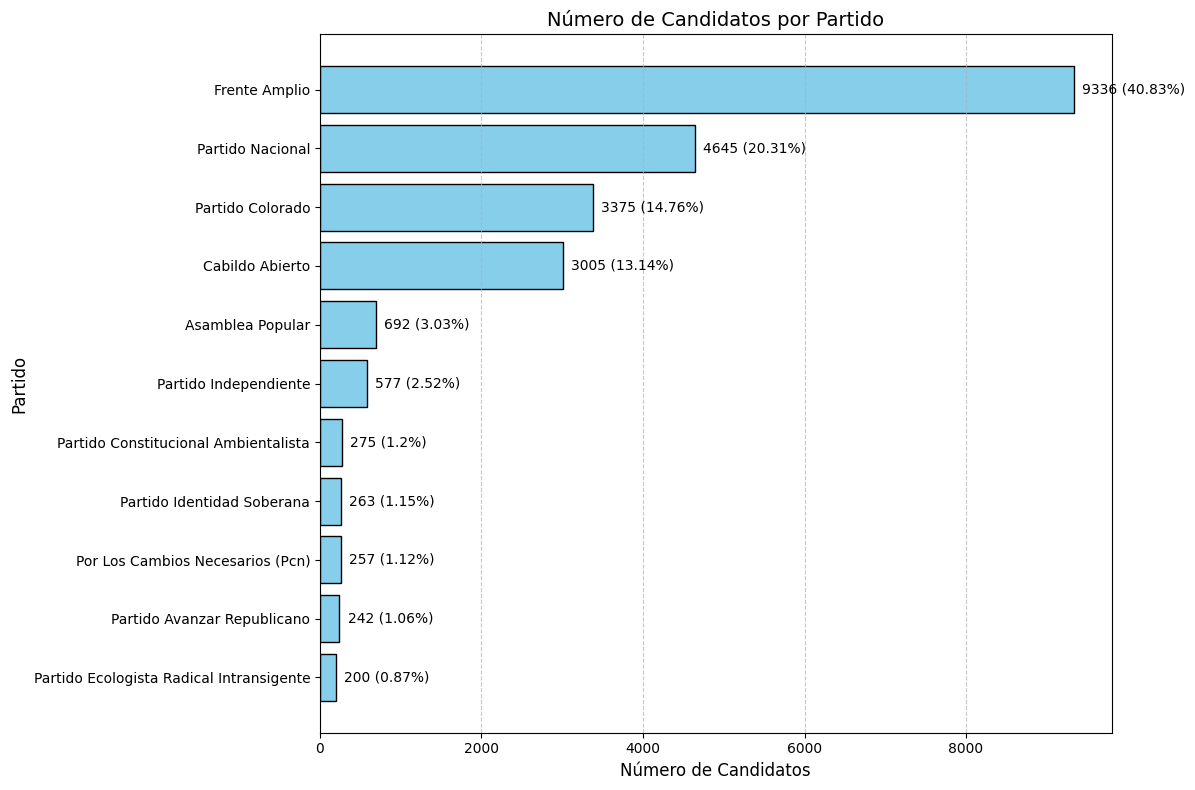

In [3]:
# Group the data to count the number of candidates per party
df_grouped = df.groupby(['CredencialSerie', 'CredencialNumero']).first().groupby('PartidoPolitico').count()

df_reset = df_grouped.reset_index()

# Renaming columns for clarity
df_reset = df_reset.rename(columns={"PartidoPolitico": "Partido", "Numero": "Candidatos"})

# Normalizing party names (capitalize each word)
df_reset["Partido"] = df_reset["Partido"].str.title()

# Calculating relative percentages
total_candidates = df_reset["Candidatos"].sum()
df_reset["Porcentaje"] = (df_reset["Candidatos"] / total_candidates * 100).round(2)

# Sorting by number of candidates for better visualization
df_sorted = df_reset.sort_values("Candidatos", ascending=False)

# Create a horizontal bar chart
plt.figure(figsize=(12, 8))
bars = plt.barh(df_sorted["Partido"], df_sorted["Candidatos"], color="skyblue", edgecolor="black")

# Adding the numbers and percentages to each bar
for i, bar in enumerate(bars):
    plt.text(
        bar.get_width() + 100,  # Position text slightly to the right of the bar
        bar.get_y() + bar.get_height() / 2,  # Center the text vertically
        f'{df_sorted["Candidatos"].iloc[i]} ({df_sorted["Porcentaje"].iloc[i]}%)',
        va='center', ha='left', fontsize=10
    )

# Customizing the plot
plt.xlabel("Número de Candidatos", fontsize=12)
plt.ylabel("Partido", fontsize=12)
plt.title("Número de Candidatos por Partido", fontsize=14)
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.grid(axis="x", linestyle="--", alpha=0.7)  # Add grid lines for the x-axis
plt.tight_layout()

plt.savefig('output/n_candidates_party.png')
plt.show()

In [4]:
df['zona'] = df['CredencialSerie'].apply(
    lambda x: 'Montevideo' if str(x).startswith(('A', 'B')) else ('Canelones' if str(x).startswith('C') else 'Interior'))

In [5]:
df_votos=pd.read_excel(folder+'totales-generales-por-comision-receptora-de-votos-y-plebiscitos-constitucionales.xlsx')
df_votos['zona'] = df_votos['Serie'].apply(
    lambda x: 'Montevideo' if str(x).startswith(('A', 'B')) else ('Canelones' if str(x).startswith('C') else 'Interior'))

C:\Users\guill\AppData\Local\Temp\ipykernel_55432\3826834659.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_votos_grouped = df_votos.groupby("zona").sum()


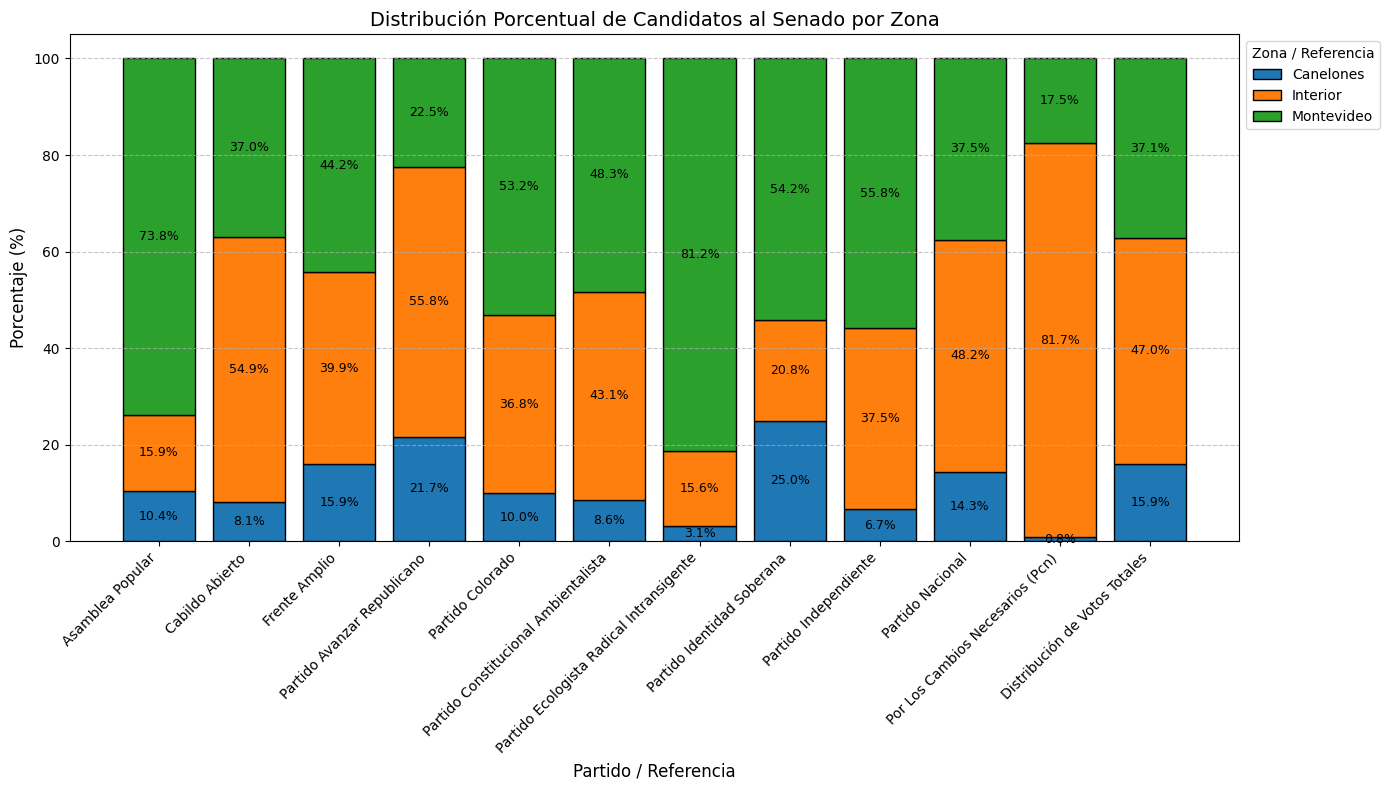

In [6]:
# Group the votes by zone and calculate the total
df_votos_grouped = df_votos.groupby("zona").sum()

# Calculate the percentage distribution of votes emitted across zones
df_votos_grouped["PorcentajeVotos"] = (df_votos_grouped["TotalVotosEmitidos"] / df_votos_grouped["TotalVotosEmitidos"].sum()) * 100

# Group the candidates by party and zone
df_grouped = df[df['Candidatura'] == 'SENADOR'] \
    .groupby(['CredencialSerie', 'CredencialNumero']).first() \
    .groupby(['zona', 'PartidoPolitico']).count()

# Resetting the index to access zones and parties
df_reset = df_grouped.reset_index()

# Renaming columns for clarity
df_reset = df_reset.rename(columns={"PartidoPolitico": "Partido", "Numero": "Candidatos"})

# Creating a pivot table to structure the data for percentage calculation
pivot_table = df_reset.pivot(index="Partido", columns="zona", values="Candidatos").fillna(0)

# Normalize party names (capitalize each word)
pivot_table.index = pivot_table.index.str.title()

# Calculate row-wise percentages
pivot_table_percentage = pivot_table.div(pivot_table.sum(axis=1), axis=0) * 100

# Append the reference data for `TotalVotosEmitidos` as the last row
reference_values = df_votos_grouped["PorcentajeVotos"].values
pivot_table_percentage.loc["Distribución de Votos Totales"] = reference_values

# Plot the stacked bar chart for candidate distribution with reference column
fig, ax = plt.subplots(figsize=(14, 8))

# Plotting the stacked bar chart for all parties including the reference
zones = pivot_table_percentage.columns
bottom = np.zeros(len(pivot_table_percentage))

for zone in zones:
    bar = ax.bar(
        pivot_table_percentage.index,
        pivot_table_percentage[zone],
        bottom=bottom,
        label=zone,
        edgecolor="black",
    )
    for i, (value, b) in enumerate(zip(pivot_table_percentage[zone], bottom)):
        if value > 0:  # Only label non-zero values
            ax.text(
                i, b + value / 2, f"{value:.1f}%", ha="center", va="center", fontsize=9
            )
    bottom += pivot_table_percentage[zone]

# Customizing the plot
ax.set_title("Distribución Porcentual de Candidatos al Senado por Zona", fontsize=14)
ax.set_xlabel("Partido / Referencia", fontsize=12)
ax.set_ylabel("Porcentaje (%)", fontsize=12)
ax.set_xticks(range(len(pivot_table_percentage.index)))
ax.set_xticklabels(pivot_table_percentage.index, rotation=45, ha="right", fontsize=10)
ax.legend(title="Zona / Referencia", loc="upper left", bbox_to_anchor=(1, 1))
ax.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()

plt.savefig('output/share_candidates_region_party.png')
plt.show()

In [ ]:
df_votos_partidos=pd.read_excel(folder+'desglose-de-votos.xlsx')

In [ ]:
count_rel=pd.merge(df[['CredencialSerie', 'CredencialNumero']].drop_duplicates().groupby('CredencialSerie').count().reset_index(),df_votos.groupby('Serie').sum()[['TotalVotosEmitidos']].reset_index(), left_on='CredencialSerie',right_on='Serie')

In [ ]:
# Complete municipio mapping based on the PDF
municipio_mapping = {

    # General Municipalities
    "Municipio A": ["BSA", "BTA", "BTB", "BTC", "BTD", "BUA", "BUB", "BVA", "BVB", "BVC", "BXA", "BXB", "BXC", "BSB"],
    "Municipio B": [
        "AAA", "ACA", "AIA", "AKA", "AMA", "APA", "ARA", "ASA", "ATA", "AVA", "BEA", "BFA", "BJB", "BKB", 
        "AAB", "ABA", "ABB", "ACB", "ADA", "ADB", "AEA", "AEB", "AFA", "AFB", "AGA", "AGB", "AHA", "AHB", 
        "AIB", "AJA", "AJB", "AKB", "ALA", "ALB", "AMB", "ANA", "ANB", "AOA", "AOB", "APB", "AQA", "AQB", 
        "ARB", "ASB", "AVB", "BEB", "BFB"
    ],
    "Municipio C": [
        "BGA", "BJA", "BKA", "BLA", "BLB", "BMA", "BMB", "BNA", "BPA", "BPB", "BQA", "BQB",
        "BGB", "BHA", "BIA", "BIB", "BHB"
    ],
    "Municipio CH": ["ATB", "AUA", "AUB", "AXA", "AXB", "AZA", "AZB", "BAA", "BAB"],
    "Municipio D": ["BBA", "BBB", "BBC", "BBD", "BDD", "BNB", "BNC", "BOA", "BOB"],
    "Municipio E": ["BCA", "BCB", "BCC", "BCD", "BCE", "BCF", "BCG"],
    "Municipio F": ["BDA", "BDB", "BDC", "BDE", "BDF"],
    "Municipio G": ["BRA", "BRB", "BRC", "BZA", "BZB", "BZC"],
    # Canelones
    "Ciudad de la Costa": ["CMF", "CMI", "CMJ"],
    "Las Piedras": ["CDA", "CDD", "CDE"],
    "Pando": ["CMA"],
    "La Paz": ["CEA"],
    "Canelones": ["CAA", "CNA"],
    "Santa Lucía": ["CBA", "CBB", "CBC"],
    "Progreso": ["CDB"],
    "Paso Carrasco": ["CMD"],
    "Barros Blancos": ["CME"],
    "Colonia Nicolich": ["CMK"],
    "San Ramón": ["CIA"],
    "Salinas": ["CMG"],
    "Suárez": ["CQA", "CQC"],
    "Parque del Plata": ["CMH"],
    "Sauce": ["CFA"],
    "Tala": ["CJA", "CJB"],
    "Atlántida": ["CMC"],
    "Toledo": ["CQB"],
    "Empalme Olmos": ["CMB"],
    "San Jacinto": ["CHA"],
    "Santa Rosa": ["CGA"],
    "La Floresta": ["CLB", "CLC"],
    "Migues": ["CKA"],
    "Los Cerrillos": ["CCA", "CEB"],
    "San Bautista": ["CPA"],
    "Soca": ["CLA", "CLD", "CLE"],
    "Montes": ["CKB"],
    "San Antonio": ["COA"],
    "Aguas Corrientes": ["CCB"],
    "18 de Mayo": ["CDC"],
    # Maldonado
    "Maldonado": ["DAA", "DAC", "DAE", "DAF", "DAG", "DAH", "DAI", "DAJ", "DAD"],
    "San Carlos": ["DBA", "DBB", "DBC", "DDA", "DDB", "DDC", "DED", "DEE", "DEF", "DBD", "DBE", "DBF", "DBG", "DEH"],
    "Piriápolis": ["DCB"],
    "Punta del Este": ["DAB", "DAK"],
    "Pan de Azúcar": ["DCA", "DCC"],
    "Aiguá": ["DDD", "DFA", "DFB"],
    "Solís Grande": ["DCD", "DCE", "DCF"],
    "Garzón": ["DEA", "DEC", "DEB", "DEG"],
    # Rocha
    "Chuy": ["EFB"],
    "Castillos": ["EDC", "ECB"],
    "Lascano": ["EEA"],
    "La Paloma": ["ECG"],
    # Treinta y Tres
    "Vergara": ["FBA"],
    "Santa Clara de Olimar": ["FDA"],
    "Cerro Chato": ["FDB"],
    "General Enrique Martínez": ["FBC"],
    "Villa Sara": ["FEA"],
    "Rincón": ["FBE"],
    # Cerro Largo
    "Río Branco": ["GDA", "GDB", "GDC", "GDD", "GDH"],
    "Fraile Muerto": ["GFB"],
    "Isidoro Noblía": ["GEC", "GED", "GEF"],
    "Aceguá": ["GEE"],
    "Tupambaé": ["GGA", "GGC"],
    "Plácido Rosas": ["GCA"],
    "Arévalo": ["GGD", "GGE", "GGF", "GGG", "GGH"],
    "Arbolito": ["GCC", "GCE"],
    "Ramón Trigo": ["GFD"],
    "Bañado de Medina": ["GFE"],
    "Las Cañas": ["GCF", "GDE", "GDG"],
    "Cerro de las Cuentas": ["GCD", "GFC"],
    "Centurión": ["GDF", "GEA"],
    "Tres Islas": ["GFA"],
    "Quebracho": ["GGB"],
    # Rivera
    "Tranqueras": ["HCC", "HCD", "HCG"],
    "Vichadero": ["HFG"],
    "Minas de Corrales": ["HDB"],
    # Artigas
    "Bella Unión": ["ICD", "ICE", "ICF"],
    "Tomás Gomensoro": ["ICC"],
    "Baltasar Brum": ["ICA"],
    # Salto
    "Villa Constitución": ["JDB", "JDC", "JDD"],
    "Pueblo Belén": ["JDE"],
    "Pueblo Rincón de Valentín": ["JEC"],
    "Colonia Lavalleja": ["JEA", "JEB"],
    "Pueblo San Antonio": ["JCA"],
    "Mataojo": ["JFD", "JFE", "JFF", "JFG"],
    # Paysandú
    "Guichón": ["KEA", "KEB", "KEC", "KED"],
    "Quebracho": ["KFA", "KFC"],
    "Porvenir": ["KCD", "KCE", "KDA", "KDB", "KDD", "KDE"],
    "Piedras Coloradas": ["KGA", "KGB"],
    "Lorenzo Geyres": ["KGC", "KFB"],
    "Tambores": ["KHA", "KHB", "KEE", "KEF"],
    "Chapicuy": ["KID", "KIE"],
    # Río Negro
    "Young": ["LBC", "LBD"],
    "Nuevo Berlín": ["LAB"],
    "San Javier": ["LBA"],
    # Soriano
    "Dolores": ["MCA", "MCB"],
    "Cardona": ["MFA"],
    "José Enrique Rodó": ["MEE", "MFC"],
    "Palmitas": ["MGJ"],
    # Colonia
    "Carmelo": ["NHB"],
    "Juan L. Lacaze": ["NLB", "NLC"],
    "Nueva Helvecia": ["NEB"],
    "Rosario": ["NCB"],
    "Nueva Palmira": ["NIB"],
    "Tarariras": ["NBD"],
    "Ombúes de Lavalle": ["NGA", "NGB"],
    "Colonia Valdense": ["NDB"],
    "Florencio Sánchez": ["NFC"],
    "Colonia Miguelete": ["NBB", "NBC"],
    "La Paz (Colonia)": ["NDA"],
    # San José
    "Ciudad del Plata": ["OEI", "OGA", "OGB", "OGC", "OGD", "OGE"],
    "Libertad": ["OEA", "OEB", "OEH"],
    "Rodríguez": ["OCH", "ODA", "ODB", "ODC", "ODE", "ODF", "ODG"],
 "Ecilda Paullier": ["OFE", "OFF", "OFG"],
    # Flores
    "Ismael Cortinas": ["PBD"],
    # Florida
    "Sarandí Grande": ["QCA"],
    "Casupá": ["QDC"],
    "Fray Marcos": ["QDD"],
    # Durazno
    "Sarandí del Yí": ["RDC", "RDD", "RDE"],
    "Villa del Carmen": ["RCC", "RCD"],
    # Lavalleja
    "José Pedro Varela": ["SHD"],
    "Solís de Mataojo": ["SCC"],
    "José Batlle y Ordóñez": ["SIE"],
    "Mariscala": ["SGC"],
    # Tacuarembó
    "Paso de los Toros": ["TFD"],
    "San Gregorio de Polanco": ["TED"],
    "Ansina": ["TBE"]
}

# Function to assign municipio based on SERIE
def assign_municipio(serie):
    for municipio, series in municipio_mapping.items():
        if serie in series:
            return municipio
    return None

count_rel['municipio'] = count_rel['Serie'].apply(assign_municipio)

capitales_departamentales = [
    "ARTIGAS", "MELO", "COLONIA DEL SACRAMENTO", "DURAZNO", 
    "TRINIDAD", "FLORIDA", "MINAS", "MALDONADO", "PAYSANDÚ", 
    "FRAY BENTOS", "RIVERA", "ROCHA", "SALTO", "SAN JOSÉ DE MAYO", 
    "MERCEDES", "TACUAREMBÓ", "TREINTA Y TRES"
]
def assign_capital(serie):
    if serie in capitales_departamentales:
        return serie

df_24=pd.read_csv(folder+'series2024.csv')
df_24.loc[df_24['LOCALIDAD'].fillna('').str.startswith('B°'), 'LOCALIDAD'] = 'TACUAREMBÓ'
df_24.loc[df_24['LOCALIDAD']=='EL GENERAL', 'LOCALIDAD'] = "COLONIA DEL SACRAMENTO"
df_24.loc[df_24['LOCALIDAD']=='EL GENERAL', 'LOCALIDAD'] = "REAL DE SAN CARLOS"

df_24['municipio'] = df_24['LOCALIDAD'].apply(assign_capital)
df_24.groupby('SERIE').first().reset_index()[['SERIE','municipio']]

#Filter rows where df_24['municipio'] is not NaN
filtered_df_24 = df_24[~df_24['municipio'].isna()]

#Create a mapping from df_24 using 'serie' to 'municipio'
serie_to_municipio_mapping = filtered_df_24.set_index('SERIE')['municipio'].to_dict()

#Replace only NaN values in count_rel['municipio'] based on 'serie'
count_rel['municipio'] = count_rel['municipio'].fillna(count_rel['Serie'].map(serie_to_municipio_mapping))
count_rel['municipio'] = count_rel['municipio'].fillna(count_rel['Serie'].map(df_24.set_index('SERIE')['LOCALIDAD'].to_dict()))

In [ ]:
count_munic=count_rel.groupby('municipio').sum()
count_munic['relativo']=count_munic['CredencialNumero']/count_munic['TotalVotosEmitidos']*100

# Filter and sort the data by 'relativo' in descending order
filtered_data = count_munic[count_munic['TotalVotosEmitidos'] > 2000].sort_values(by='relativo', ascending=False)

# Normalize city names (capitalize each word)
filtered_data.index = filtered_data.index.str.title()

# Plotting 'relativo' as a horizontal bar chart with highest at the top
plt.figure(figsize=(10, 14))
bars = plt.barh(
    filtered_data.index.astype(str),  # Use normalized city names
    filtered_data['relativo'],
    color="skyblue",
    edgecolor="black"
)

# Adding values at the end of each bar
for bar in bars:
    width = bar.get_width()
    plt.text(
        width + 0.1,  # Position slightly to the right of the bar
        bar.get_y() + bar.get_height() / 2,  # Vertically centered
        f"{width:.1f}%",  # Format the value as a percentage
        va="center",
        fontsize=9
    )

# Adding plot details in Spanish
plt.title("Porcentaje de votantes que son candidatos por ciudad", fontsize=14)
plt.xlabel("Porcentaje de votantes que son candidatos", fontsize=12)
plt.ylabel("Nombre de la ciudad", fontsize=12)
plt.gca().invert_yaxis()  # Invert the y-axis to have the highest at the top
plt.grid(axis='x', linestyle="--", alpha=0.7)

# Show the plot
plt.tight_layout()
plt.savefig('output/share_candidates_region.png')

plt.show()

In [ ]:
df_votos_partidos['municipio'] = df_votos_partidos['Series'].apply(assign_municipio)

# Candidatos por localidad en cada partido

In [ ]:
# partido could be 'FRENTE AMPLIO', 'PARTIDO NACIONAL', 'PARTIDO COLORADO', 'CABILDO ABIERTO'
def share_votos_cands(partido):
    df_fa=df[df['PartidoPolitico']==partido]
    df_fa=pd.merge(df_fa[['CredencialSerie', 'CredencialNumero']].drop_duplicates().groupby('CredencialSerie').count().reset_index(),df_votos.groupby('Serie').sum()[['TotalVotosEmitidos']].reset_index(), left_on='CredencialSerie',right_on='Serie')
    df_fa['municipio'] = df_fa['Serie'].apply(assign_municipio)
    count_munic_fa=df_fa.groupby('municipio').sum()
    count_munic_fa['relativo']=count_munic_fa['CredencialNumero']/count_munic['TotalVotosEmitidos'] 
    # Filter and sort the data by 'relativo' in descending order
    filtered_data = count_munic_fa[count_munic_fa['TotalVotosEmitidos'] > 2000].sort_values(by='relativo', ascending=False)

    # Normalize city names (capitalize each word)
    filtered_data.index = filtered_data.index.str.title()

    # Plotting 'relativo' as a horizontal bar chart with highest at the top
    plt.figure(figsize=(10, 14))
    bars = plt.barh(
        filtered_data.index.astype(str),  # Use normalized city names
        filtered_data['relativo'],
        color="purple",
        edgecolor="black"
    )

    # Adding values at the end of each bar
    for bar in bars:
        width = bar.get_width()
        plt.text(
            width + 0.001,  # Position slightly to the right of the bar
            bar.get_y() + bar.get_height() / 2,  # Vertically centered
            f"{width:.3f}%",  # Format the value as a percentage
            va="center",
            fontsize=9
        )

    # Adding plot details in Spanish
    plt.title("Porcentaje de votantes que son candidatos del "+partido+" por ciudad", fontsize=14)
    plt.xlabel("Porcentaje de votantes que son candidatos", fontsize=12)
    plt.ylabel("Nombre de la ciudad", fontsize=12)
    plt.gca().invert_yaxis()  # Invert the y-axis to have the highest at the top
    plt.grid(axis='x', linestyle="--", alpha=0.7)

    # Show the plot
    plt.tight_layout()
    plt.savefig('output/share_candidates_region_'+partido+'.png')

    plt.show()
    
for i in ['FRENTE AMPLIO', 'PARTIDO NACIONAL', 'PARTIDO COLORADO', 'CABILDO ABIERTO']:
    share_votos_cands(i)

# Votos y Candidatos por partido

In [ ]:
partido_to_lema = {
    'Partido Frente Amplio': 'FRENTE AMPLIO',
    'Partido Nacional                                  ': 'PARTIDO NACIONAL',
    'Partido Colorado                                  ': 'PARTIDO COLORADO',
    'Partido Cabildo Abierto                           ': 'CABILDO ABIERTO'
}
# partido could be 'Partido Frente Amplio', 'Partido Nacional', 'Partido Colorado', 'Partido Cabildo Abierto'
def scatter_votos_candidatos(partido):
    votos_fa=pd.merge(df_votos_partidos.groupby(['Lema','municipio']).sum().reset_index(), count_munic, on='municipio')
    votos_fa=votos_fa[votos_fa['Lema']==partido]
    votos_fa['relativo']=votos_fa['CantidadVotos']/votos_fa['TotalVotosEmitidos']

    lema = partido_to_lema[partido]
    df_fa=df[df['PartidoPolitico']==lema]
    df_fa=pd.merge(df_fa[['CredencialSerie', 'CredencialNumero']].drop_duplicates().groupby('CredencialSerie').count().reset_index(),df_votos.groupby('Serie').sum()[['TotalVotosEmitidos']].reset_index(), left_on='CredencialSerie',right_on='Serie')
    df_fa['municipio'] = df_fa['Serie'].apply(assign_municipio)
    count_munic_fa=df_fa.groupby('municipio').sum()
    count_munic_fa['relativo']=count_munic_fa['CredencialNumero']/count_munic['TotalVotosEmitidos'] 

    # Merge the datasets on 'municipio'
    merged_df = pd.merge(count_munic_fa.reset_index(), votos_fa, on='municipio')

    # Create a scatter plot of 'relativo_x' vs. 'relativo_y'
    plt.figure(figsize=(8, 6))
    plt.scatter(merged_df['relativo_x'], merged_df['relativo_y'], alpha=0.7, color='purple')
    plt.title('Votos y Candidatos - '+partido)
    plt.xlabel('Porcentaje de votantes que son candidatos del '+partido)
    plt.ylabel('Porcentaje de votantes que votan '+partido)
    plt.grid(True)

    # Identify the top 3 municipios in both dimensions
    top_x = merged_df.nlargest(3, 'relativo_x')
    top_y = merged_df.nlargest(3, 'relativo_y')

    # Combine and remove duplicates
    top_municipios = pd.concat([top_x, top_y]).drop_duplicates()

    # Annotate the top municipios on the scatter plot
    for _, row in top_municipios.iterrows():
        plt.annotate(row['municipio'], (row['relativo_x'], row['relativo_y']),
                     textcoords="offset points", xytext=(0, 10), ha='center', fontsize=9)

    # Show the plot
    plt.savefig('output/scatter_'+partido+'.png')

    plt.show()

for i in ['Partido Frente Amplio', 'Partido Nacional                                  ', 'Partido Colorado                                  ', 'Partido Cabildo Abierto                           ']:
    scatter_votos_candidatos(i)

# Mapas

In [ ]:
geo_df = gpd.read_file(folder+"combined_departments.geojson")

In [ ]:
# partido could be 'FRENTE AMPLIO', 'PARTIDO NACIONAL', 'PARTIDO COLORADO', 'CABILDO ABIERTO'
# depto could be 'Montevideo' or 'Canelones'
def mapa_partido_depto(partido, depto):
    df_fa=df[df['PartidoPolitico']==partido]
    df_fa=pd.merge(df_fa[['CredencialSerie', 'CredencialNumero']].drop_duplicates().groupby('CredencialSerie').count().reset_index(),df_votos.groupby('Serie').sum()[['TotalVotosEmitidos']].reset_index(), left_on='CredencialSerie',right_on='Serie', how='outer').fillna(0)
    df_fa['relativo']=df_fa['CredencialNumero']/df_fa['TotalVotosEmitidos']*100
    df_fa[df_fa['TotalVotosEmitidos']>1000].sort_values(by='relativo').tail(50)
    # Filter geo_df for series starting with 'A' or 'B'
    if depto=='Montevideo':
        filtered_geo_df = geo_df[geo_df['serie'].str.startswith(('A', 'B'))]
    elif depto=='Canelones':
        filtered_geo_df = geo_df[geo_df['serie'].str.startswith(('C'))]
    # Merge the filtered GeoDataFrame with df_fa to include 'relativo'
    merged_geo_df = filtered_geo_df.merge(df_fa[['Serie', 'relativo']], left_on='serie', right_on='Serie', how='inner')

    # Plot the filtered and merged GeoDataFrame
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    merged_geo_df.plot(column='relativo', cmap='Purples', legend=True, ax=ax, edgecolor='grey')
    ax.set_title("Mapa de porcentaje de candidatos por serie - "+partido+" - "+depto)
    ax.axis('off')  # Remove axes for a cleaner look
    plt.savefig('output/map_'+depto+'_'+partido+'.png')
    plt.show()

for i in ['FRENTE AMPLIO', 'PARTIDO NACIONAL', 'PARTIDO COLORADO', 'CABILDO ABIERTO']:
    for j in ['Montevideo', 'Canelones']:
        mapa_partido_depto(i,j)

# NBS

In [ ]:
nbs=pd.read_excel(folder+'nbs.xlsx')

In [ ]:
count_munic=count_rel.groupby('municipio').sum()
count_munic['relativo']=count_munic['CredencialNumero']/count_munic['TotalVotosEmitidos']*100
count_munic.sort_values(by='relativo')
count_munic[count_munic['TotalVotosEmitidos']>2000].sort_values(by='relativo').head(10)
count_munic = count_munic.reset_index()
count_munic['municipio'] = count_munic['municipio'].str.lower()
nbs['Municipio'] = nbs['Municipios'].str.lower()

# Convert 'nbs' in nbs DataFrame to a numeric type
nbs['nbs'] = nbs['NBS'].str.replace(',', '.').astype(float)


# Merge the two DataFrames on the processed columns
merged_df = pd.merge(nbs, count_munic, right_on='municipio', left_on='Municipio', how='inner')
merged_df = merged_df.dropna(subset=['relativo', 'nbs'])

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(merged_df['relativo'], merged_df['nbs'])

# Generate regression line
x = np.linspace(merged_df['relativo'].min(), merged_df['relativo'].max(), 100)
y = slope * x + intercept

# Scatter plot with regression line
plt.figure(figsize=(8, 6))
plt.scatter(merged_df['relativo'], merged_df['nbs'], alpha=0.7, label='Data points')
plt.plot(x, y, color='red', label=f'Fit: y = {slope:.2f}x + {intercept:.2f}')
plt.title('Personas con NBS y Candidatos')
plt.xlabel('Porcentaje de votantes que son Candidatos')
plt.ylabel('Porcentaje de Individuos con NBS')
plt.legend()
plt.grid(True)
plt.savefig('output/nbs.png')

plt.show()

